KMEAN USING MAHALANOBIS DISTANCE 

In [1]:


import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
from scipy.spatial import distance



In [2]:
path = "Data/FR_youtube_trending_data.csv"
df = pd.read_csv(path)

df.drop_duplicates(subset ="video_id", keep = 'first', inplace=True)



In [3]:
subset = df[['video_id','likes','view_count','comment_count','dislikes']]
subset.head()

,video_id,likes,view_count,comment_count,dislikes
0,7rlwxSPUcQk,165557,1943013,15777,4198
1,AcBd_RH9JSw,346839,1823553,8030,2767
2,JVm8P6kKgD0,22362,196340,1148,187
3,JfgeD7xWy-w,29561,311609,3213,418
4,P3IkBxra3a8,10471,100691,384,90


In [4]:
X = subset.drop(columns='video_id')

<AxesSubplot:>

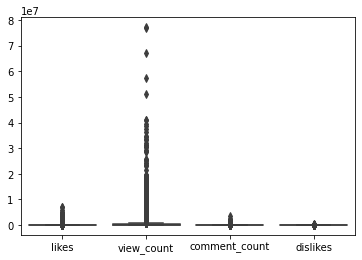

In [5]:
sns.boxplot(data=X)

In [6]:
X = X.apply(zscore)

outlier_mask = X[(~(X<3).all(axis=1))].index

In [7]:
X.head()

,likes,view_count,comment_count,dislikes
0,0.516884,0.674497,0.220688,0.704318
1,1.356086,0.616360,0.063768,0.417316
2,-0.146003,-0.175543,-0.075632,-0.100129
3,-0.112677,-0.119446,-0.033804,-0.053800
4,-0.201049,-0.222092,-0.091107,-0.119583


Text(0.5, 0.92, '3D plot of KMeans Clustering')

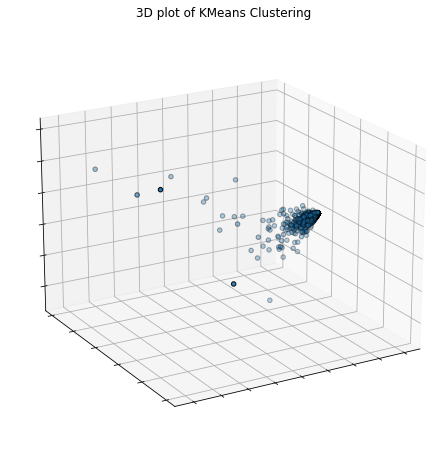

In [9]:
pca = PCA(n_components=3, svd_solver='randomized',random_state=42)

visu = pd.DataFrame(pca.fit_transform(X),columns=["vis1","vis2","vis3"])

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(visu.iloc[:, 0], visu.iloc[:, 1], visu.iloc[:, 2], edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title('3D plot of KMeans Clustering')

In [10]:
def centroids_init(X,k):
    
    # Initialise all points to cluster 0 and select a random centroid point
    idx = np.random.choice(len(X), 1, replace=False)
    centroids = X[idx, :]
    dist = 0

    P = np.array([0]*len(X))

    # Find the farthest record from centroids and select that point as a new centroid
    # Repeat search for new centroid for cluster 1 to cluster k
    for i in range(1, k):
        dist = [distance.mahalanobis(X[0, :], 
                                     np.array(centroids)[clu], 
                                     np.linalg.inv(np.cov(X[P==clu, :], rowvar=0))) for clu in range(i)]
        for idx in range(1, len(X)):
            dist = np.vstack((dist, [distance.mahalanobis(X[idx, :], 
                                                          np.array(centroids)[clu], 
                                                          np.linalg.inv(np.cov(X[P==clu, :], rowvar=0))) for clu in range(i)]))
        centroids = np.vstack((centroids, X[np.argmax(np.max(dist,axis=1)), :]))
        P = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
    return(centroids)

In [11]:
def kmeans_mahalanobis_new(X,k=3,max_iterations=6):

    # Check if data is in DataFrame form and change to array
    if isinstance(X, pd.DataFrame):X = X.values
    
    # Initialise required number of Centroids
    centroids = centroids_init(X,k)
    
    # Create initial cluster with Euclidean distance
    P = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
    
    # Loop through max_iterations times
    for _ in range(max_iterations):
        
        # Find Mahalanobish distance for each datapoint
        dist = [distance.mahalanobis(X[0, :], 
                                     np.array(centroids)[clu], 
                                     np.linalg.inv(np.cov(X[P==clu, :], rowvar=0))) for clu in range(k)]
        for idx in range(1, len(X)):
            dist = np.vstack((dist, [distance.mahalanobis(X[idx, :], 
                                                          np.array(centroids)[clu], 
                                                          np.linalg.inv(np.cov(X[P==clu, :], rowvar=0))) for clu in range(k)]))
        tmp = np.argmin(dist,axis=1)
        
        # Update centroids to cluster means
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        
        # If clusters are stable then stop early
        if np.array_equal(P,tmp):break
        P = tmp
    return(P)

In [12]:
# Initiate cluster numbers
k=5

# Repeat process till conditions are satisfied else leave with fail message
c = 0
while True:

    try:
        prediction=kmeans_mahalanobis_new(X.drop(outlier_mask), k=k)
        if len(np.unique(prediction))==k:
            break
    except:
        print("Reinitialising")
        c+=1
        if c == 7:
            print("Failed too many times")
            break
prediction

/usr/local/python/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/python/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_3738/3919519143.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  np.linalg.inv(np.cov(X[P==clu, :], rowvar=0))) for clu in range(i)]
/usr/local/python/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/python/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_3738/3919519143.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice
  np.linalg.inv(np.cov(X[P==clu, :], rowvar=0))) for clu in range(i)]))
/tmp/ipykernel_3738/1279514566.py:18: RuntimeWarning: Degre

Reinitialising
